# Time Series Forecasting - Temperature

In this notebook we will create a model to forecast temperature and comment it, data cleaning and handling were made in the ETL notebook.

The purpose here is to implement a simple neural network using LSTM, GRU and CNN(1d), learn how to use it and compare performance.

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 23.1 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import zipfile
import urllib

import os
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Setting Seaborn Theme
sns.set_theme(style="whitegrid", font_scale=1.4)

plt.rcParams["figure.figsize"] = (15,9)

In [3]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

Here we will load preprocessed data ( cleaned and missing values handled)

In [4]:
# Reading cleaned dataframe
df = pd.read_csv('brasilia_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True,drop=True)
print(f"DataFrame Shape: {df.shape}")

# Getting a dataframe with only temperature
temperature_df = df['Temperature']

DataFrame Shape: (87672, 2)


First we will visualize data.

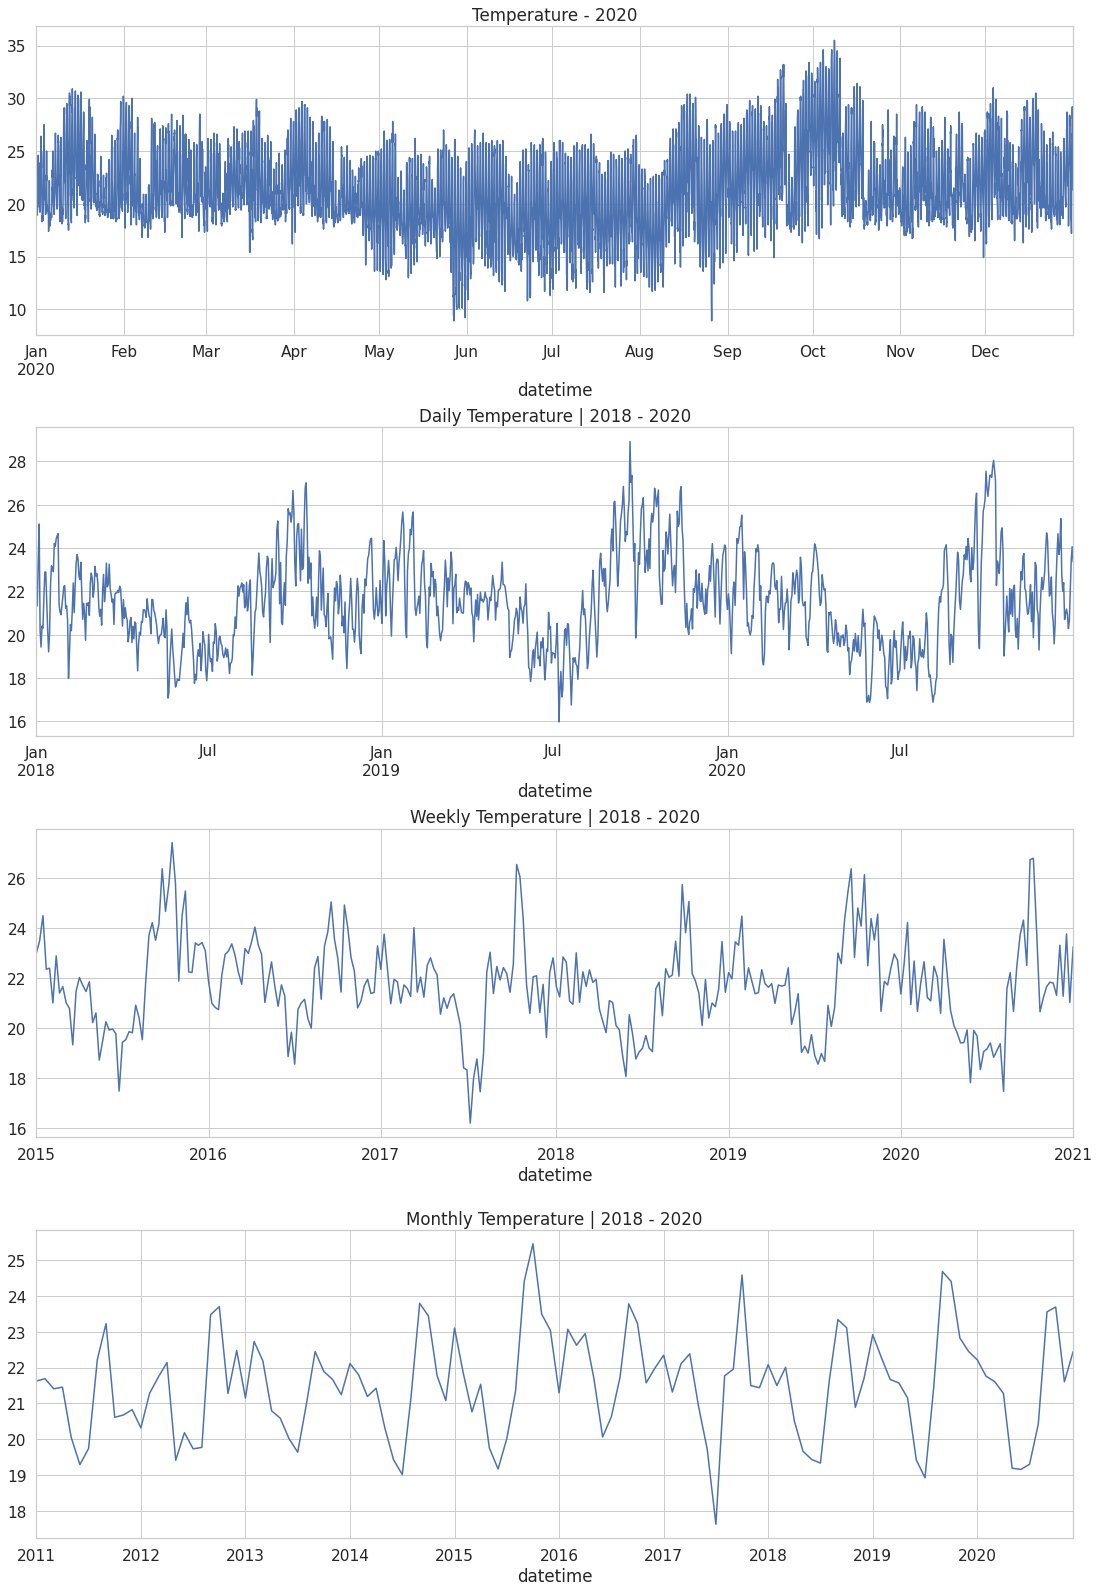

In [39]:
plt.rcParams["figure.figsize"] = (18,15)
fig1, axs = plt.subplots(nrows=4, ncols=1)

axs[0] = temperature_df['2020':].plot(ax = axs[0],title='Temperature - 2020')
axs[1] = temperature_df['2018':].resample('D').mean().plot(ax = axs[1], title='Daily Temperature | 2018 - 2020')
axs[2] = temperature_df['2015':].resample('W').mean().plot(ax = axs[2], title='Weekly Temperature | 2018 - 2020')
axs[3] = temperature_df['2011':].resample('M').mean().plot(ax = axs[3], title='Monthly Temperature | 2018 - 2020')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.1, 
                    hspace=0.3)

plt.show()

Here we can see that temperature have some seasonality, so we can take advantage of this pattern at some point in this notebook.

## First Model - Temperature and Sliding Window.

We were using only 2018 to 2020 data but we can see some sort of seasonality , which is good to use prophet, but lets see how it will behave with LSTM. Initially, without considering time itself and periodicity.

In this LSTM/GRU/CNN it will be used sliding windows as input, default will be using the last 5 hours to predict the next hour.

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

def train_test_val_split(df, window_size=5):
    X, y = df_to_X_y(temperature_df, window_size)

    total_len = len(X)
    test_val_len = int(total_len * 0.10)
    train_len = total_len - (2*test_val_len)

    X_train, y_train = X[:train_len], y[:train_len]
    X_val, y_val = X[train_len:train_len + test_val_len], y[train_len:train_len + test_val_len]
    X_test, y_test = X[train_len + test_val_len:], y[train_len + test_val_len:]

    print("_"*40)
    print("    OUTPUT SHAPE\n")
    print(f" X train: {X_train.shape}\n y train: {y_train.shape}\n\n X val: {X_val.shape}\n y val: {y_val.shape}\n\n X test: {X_test.shape}\n y test:{y_test.shape}")
    print("_"*40)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(temperature_df, 5)

________________________________________
    OUTPUT SHAPE

 X train: (70135, 5, 1)
 y train: (70135,)

 X val: (8766, 5, 1)
 y val: (8766,)

 X test: (8766, 5, 1)
 y test:(8766,)
________________________________________


In [9]:
def train_model_LSTM(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):

    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp1 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

    return model

def train_model_conv1d(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):
    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(Conv1D(64, kernel_size=2))
    model.add(Flatten())
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))


    cp = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp])

    return model

def train_model_GRU(X_train, y_train, X_val, y_val, model_name, epochs=10, learning_rate=0.0001, input_layer=(5,1)):
    model = Sequential()
    model.add(InputLayer(input_layer))
    model.add(GRU(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    cp3 = ModelCheckpoint(f'{model_name}/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[cp3])

    return model

In [10]:
def show_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name='LSTM'):
    print("_"*100)
    print(f"{model_name} Model".center(100, ' '))
    
    

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TRAIN DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_train,train_predictions)*100,2)}%')
    print('\n')
    print(train_results)
    train_results[:100].plot()
    plt.show()
    
    val_predictions = model.predict(X_val).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - VALIDATION DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_val,val_predictions)*100,2)}%')
    print('\n')
    print(val_results);
    val_results[:100].plot()
    plt.show()
    
    test_predictions = model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
    print('\n\n')
    print("_"*100)
    print(f"{model_name} Model - TEST DATA".center(100, ' '))
    print('\n')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test,test_predictions)*100,2)}%')
    print('\n')
    print(test_results)
    test_results[:100].plot()
    plt.show()

In [11]:
model_LSTM = train_model_LSTM(X_train, y_train, X_val, y_val, 'model_LSTM', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 11s 4ms/step - loss: 75.9691 - root_mean_squared_error: 8.7160 - mean_absolute_percentage_error: 28.2060 - val_loss: 7.5044 - val_root_mean_squared_error: 2.7394 - val_mean_absolute_percentage_error: 9.4384


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 2/10
2192/2192 [==============================] - 9s 4ms/step - loss: 2.5735 - root_mean_squared_error: 1.6042 - mean_absolute_percentage_error: 5.5695 - val_loss: 1.7369 - val_root_mean_squared_error: 1.3179 - val_mean_absolute_percentage_error: 4.4514


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 3/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.2978 - root_mean_squared_error: 1.1392 - mean_absolute_percentage_error: 3.8396 - val_loss: 1.4397 - val_root_mean_squared_error: 1.1999 - val_mean_absolute_percentage_error: 3.8947


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 4/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1951 - root_mean_squared_error: 1.0932 - mean_absolute_percentage_error: 3.6496 - val_loss: 1.3667 - val_root_mean_squared_error: 1.1690 - val_mean_absolute_percentage_error: 3.8735


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 5/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1680 - root_mean_squared_error: 1.0807 - mean_absolute_percentage_error: 3.5961 - val_loss: 1.3565 - val_root_mean_squared_error: 1.1647 - val_mean_absolute_percentage_error: 3.7205


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 6/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1570 - root_mean_squared_error: 1.0756 - mean_absolute_percentage_error: 3.5713 - val_loss: 1.3389 - val_root_mean_squared_error: 1.1571 - val_mean_absolute_percentage_error: 3.7135


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 7/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1469 - root_mean_squared_error: 1.0709 - mean_absolute_percentage_error: 3.5474 - val_loss: 1.3276 - val_root_mean_squared_error: 1.1522 - val_mean_absolute_percentage_error: 3.6982


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 8/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1418 - root_mean_squared_error: 1.0685 - mean_absolute_percentage_error: 3.5373 - val_loss: 1.3162 - val_root_mean_squared_error: 1.1472 - val_mean_absolute_percentage_error: 3.6963


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 9/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1369 - root_mean_squared_error: 1.0662 - mean_absolute_percentage_error: 3.5225 - val_loss: 1.3156 - val_root_mean_squared_error: 1.1470 - val_mean_absolute_percentage_error: 3.6927


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


Epoch 10/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1328 - root_mean_squared_error: 1.0643 - mean_absolute_percentage_error: 3.5141 - val_loss: 1.3092 - val_root_mean_squared_error: 1.1442 - val_mean_absolute_percentage_error: 3.7194


INFO:tensorflow:Assets written to: model_LSTM/assets


INFO:tensorflow:Assets written to: model_LSTM/assets


In [12]:
model_GRU = train_model_GRU(X_train, y_train, X_val, y_val, 'model_GRU', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 11s 4ms/step - loss: 205.6285 - root_mean_squared_error: 14.3398 - mean_absolute_percentage_error: 57.6960 - val_loss: 33.5427 - val_root_mean_squared_error: 5.7916 - val_mean_absolute_percentage_error: 19.5936


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 2/10
2192/2192 [==============================] - 9s 4ms/step - loss: 11.3701 - root_mean_squared_error: 3.3720 - mean_absolute_percentage_error: 10.7690 - val_loss: 3.7616 - val_root_mean_squared_error: 1.9395 - val_mean_absolute_percentage_error: 5.7867


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 3/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.7809 - root_mean_squared_error: 1.3345 - mean_absolute_percentage_error: 4.2288 - val_loss: 1.6661 - val_root_mean_squared_error: 1.2908 - val_mean_absolute_percentage_error: 4.0815


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 4/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.2614 - root_mean_squared_error: 1.1231 - mean_absolute_percentage_error: 3.7054 - val_loss: 1.4118 - val_root_mean_squared_error: 1.1882 - val_mean_absolute_percentage_error: 3.8362


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 5/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1844 - root_mean_squared_error: 1.0883 - mean_absolute_percentage_error: 3.6052 - val_loss: 1.3600 - val_root_mean_squared_error: 1.1662 - val_mean_absolute_percentage_error: 3.7425


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 6/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1607 - root_mean_squared_error: 1.0774 - mean_absolute_percentage_error: 3.5655 - val_loss: 1.3402 - val_root_mean_squared_error: 1.1577 - val_mean_absolute_percentage_error: 3.7503


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 7/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1486 - root_mean_squared_error: 1.0717 - mean_absolute_percentage_error: 3.5432 - val_loss: 1.3230 - val_root_mean_squared_error: 1.1502 - val_mean_absolute_percentage_error: 3.7256


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 8/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1418 - root_mean_squared_error: 1.0686 - mean_absolute_percentage_error: 3.5298 - val_loss: 1.3174 - val_root_mean_squared_error: 1.1478 - val_mean_absolute_percentage_error: 3.6997


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 9/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1365 - root_mean_squared_error: 1.0661 - mean_absolute_percentage_error: 3.5196 - val_loss: 1.3109 - val_root_mean_squared_error: 1.1449 - val_mean_absolute_percentage_error: 3.7149


INFO:tensorflow:Assets written to: model_GRU/assets


INFO:tensorflow:Assets written to: model_GRU/assets


Epoch 10/10
2192/2192 [==============================] - 9s 4ms/step - loss: 1.1313 - root_mean_squared_error: 1.0636 - mean_absolute_percentage_error: 3.5075 - val_loss: 1.3141 - val_root_mean_squared_error: 1.1463 - val_mean_absolute_percentage_error: 3.7246


In [13]:
model_conv1d = train_model_conv1d(X_train, y_train, X_val, y_val, 'model_conv1d', epochs=10, learning_rate=0.0001)

Epoch 1/10
2192/2192 [==============================] - 4s 2ms/step - loss: 3.3052 - root_mean_squared_error: 1.8180 - mean_absolute_percentage_error: 6.0217 - val_loss: 1.6419 - val_root_mean_squared_error: 1.2814 - val_mean_absolute_percentage_error: 4.1024
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 2/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.3219 - root_mean_squared_error: 1.1497 - mean_absolute_percentage_error: 3.7510 - val_loss: 1.3988 - val_root_mean_squared_error: 1.1827 - val_mean_absolute_percentage_error: 3.7325
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 3/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.2130 - root_mean_squared_error: 1.1014 - mean_absolute_percentage_error: 3.5710 - val_loss: 1.3795 - val_root_mean_squared_error: 1.1745 - val_mean_absolute_percentage_error: 3.7583
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 4/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.1929 - root_mean_squared_error: 1.0922 - mean_absolute_percentage_error: 3.5618 - val_loss: 1.3631 - val_root_mean_squared_error: 1.1675 - val_mean_absolute_percentage_error: 3.7103
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 5/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.1775 - root_mean_squared_error: 1.0851 - mean_absolute_percentage_error: 3.5555 - val_loss: 1.3453 - val_root_mean_squared_error: 1.1599 - val_mean_absolute_percentage_error: 3.7093
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 6/10
2192/2192 [==============================] - 3s 1ms/step - loss: 1.1713 - root_mean_squared_error: 1.0822 - mean_absolute_percentage_error: 3.5543 - val_loss: 1.3333 - val_root_mean_squared_error: 1.1547 - val_mean_absolute_percentage_error: 3.7066
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 7/10
2192/2192 [==============================] - 3s 1ms/step - loss: 1.1704 - root_mean_squared_error: 1.0819 - mean_absolute_percentage_error: 3.5698 - val_loss: 1.3515 - val_root_mean_squared_error: 1.1625 - val_mean_absolute_percentage_error: 3.7917
Epoch 8/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.1656 - root_mean_squared_error: 1.0796 - mean_absolute_percentage_error: 3.5687 - val_loss: 1.3336 - val_root_mean_squared_error: 1.1548 - val_mean_absolute_percentage_error: 3.7508
Epoch 9/10
2192/2192 [==============================] - 3s 1ms/step - loss: 1.1628 - root_mean_squared_error: 1.0783 - mean_absolute_percentage_error: 3.5616 - val_loss: 1.3268 - val_root_mean_squared_error: 1.1519 - val_mean_absolute_percentage_error: 3.7109
INFO:tensorflow:Assets written to: model_conv1d/assets


INFO:tensorflow:Assets written to: model_conv1d/assets


Epoch 10/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.1615 - root_mean_squared_error: 1.0777 - mean_absolute_percentage_error: 3.5683 - val_loss: 1.3793 - val_root_mean_squared_error: 1.1744 - val_mean_absolute_percentage_error: 3.8819


In [14]:
model_LSTM = load_model('model_LSTM/')
model_GRU = load_model('model_GRU/')
model_conv1d = load_model('model_conv1d/')

### Model - LSTM

____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.55%


       Train Predictions  Actuals
0              17.756216     18.2
1              18.493631     17.8
2              18.059666     18.0
3              18.508339     17.9
4              18.380917     17.9
...                  ...      ...
70130          18.659197     18.2
70131          18.682573     18.4
70132          18.994322     18.0
70133          18.391657     18.7
70134          19.342581     19.0

[70135 rows x 2 columns]


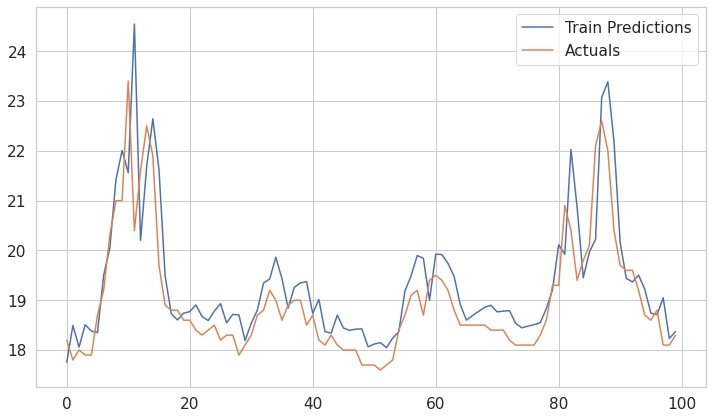




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.72%


      Val Predictions  Actuals
0           19.656191     19.6
1           20.379469     22.2
2           23.617697     24.2
3           25.430128     24.8
4           25.724577     23.4
...               ...      ...
8761        23.582300     24.0
8762        25.078814     22.8
8763        23.040964     21.6
8764        21.309479     24.6
8765        24.987047     24.5

[8766 rows x 2 columns]


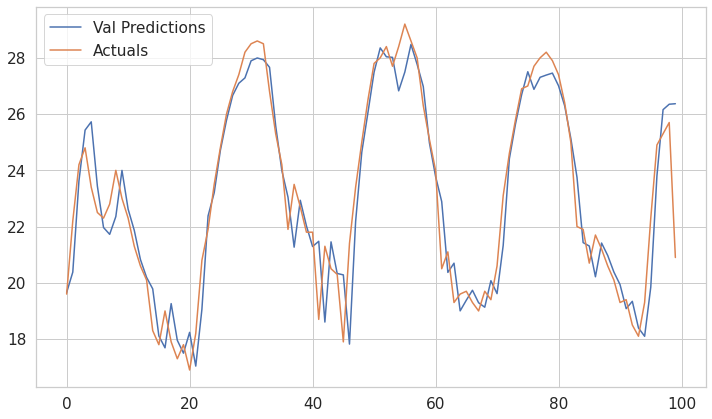




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.74%


      Test Predictions  Actuals
0            24.243414     20.0
1            19.985498     22.3
2            22.218662     23.9
3            23.873709     23.9
4            23.760462     21.7
...                ...      ...
8761         27.215582     28.1
8762         26.976061     23.6
8763         22.824827     23.6
8764         22.653454     22.3
8765         21.509039     21.3

[8766 rows x 2 columns]


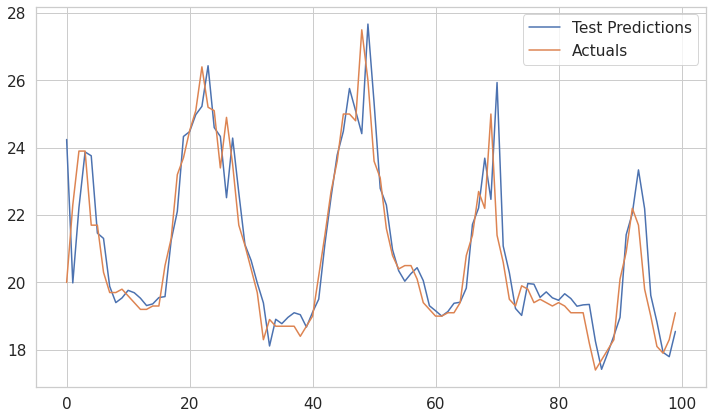

In [15]:
plt.rcParams["figure.figsize"] = (12,7)
show_model(model_LSTM, X_train, y_train, X_val, y_val, X_test, y_test)

### Model - GRU

____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.53%


       Train Predictions  Actuals
0              17.664871     18.2
1              18.515814     17.8
2              18.025076     18.0
3              18.363272     17.9
4              18.248470     17.9
...                  ...      ...
70130          18.615623     18.2
70131          18.597250     18.4
70132          18.866821     18.0
70133          18.252552     18.7
70134          19.278767     19.0

[70135 rows x 2 columns]


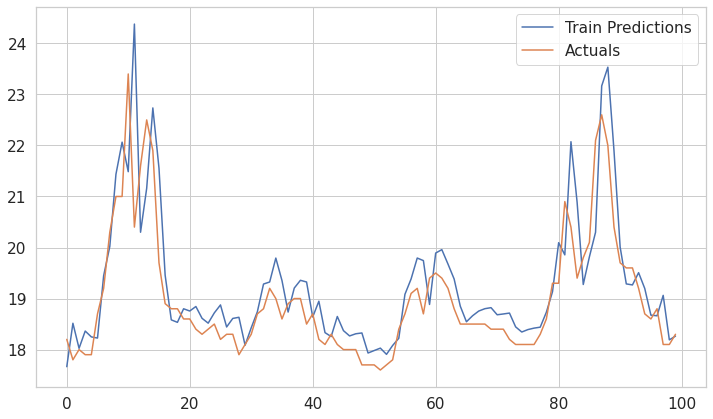




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.71%


      Val Predictions  Actuals
0           19.641645     19.6
1           20.357706     22.2
2           23.629410     24.2
3           25.451786     24.8
4           25.649593     23.4
...               ...      ...
8761        23.617785     24.0
8762        25.101591     22.8
8763        22.730408     21.6
8764        20.993399     24.6
8765        24.841448     24.5

[8766 rows x 2 columns]


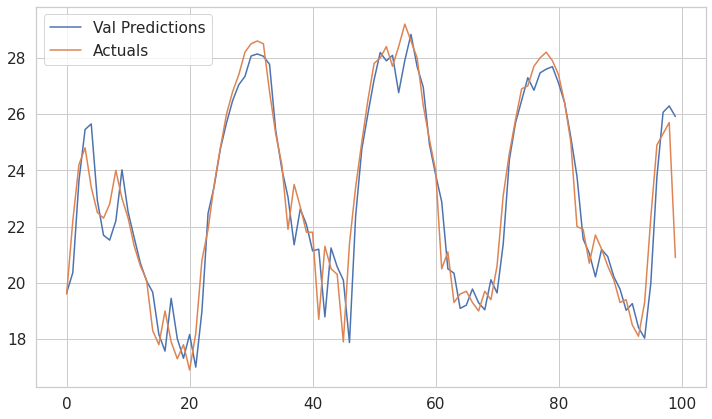




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.73%


      Test Predictions  Actuals
0            24.603416     20.0
1            20.143990     22.3
2            21.641382     23.9
3            24.208031     23.9
4            23.876135     21.7
...                ...      ...
8761         27.341257     28.1
8762         27.226648     23.6
8763         23.078325     23.6
8764         22.443317     22.3
8765         21.539345     21.3

[8766 rows x 2 columns]


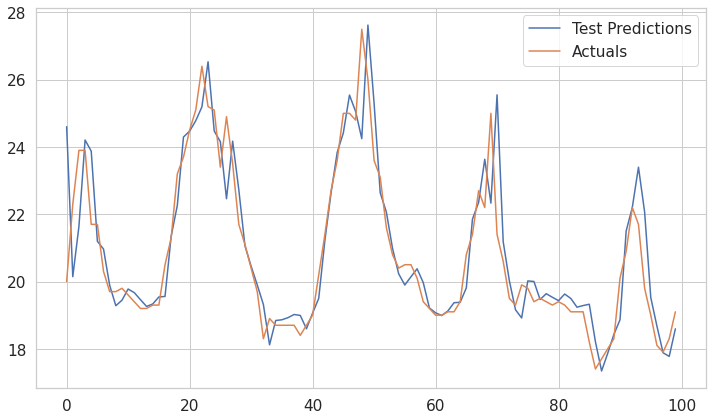

In [16]:
show_model(model_GRU, X_train, y_train, X_val, y_val, X_test, y_test, model_name='GRU')

### Model - Conv 1d

____________________________________________________________________________________________________
                                           Conv 1d Model                                            



____________________________________________________________________________________________________
                                     Conv 1d Model - TRAIN DATA                                     


MAPE: 3.51%


       Train Predictions  Actuals
0              17.610828     18.2
1              18.372021     17.8
2              17.985268     18.0
3              18.358271     17.9
4              18.250563     17.9
...                  ...      ...
70130          18.536236     18.2
70131          18.570761     18.4
70132          18.839455     18.0
70133          18.265274     18.7
70134          19.160049     19.0

[70135 rows x 2 columns]


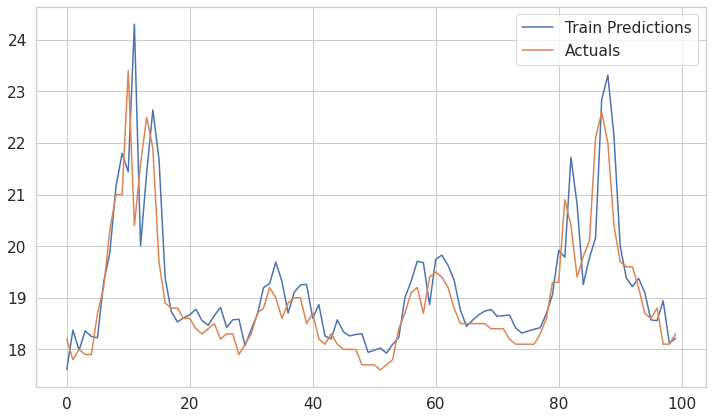




____________________________________________________________________________________________________
                                  Conv 1d Model - VALIDATION DATA                                   


MAPE: 3.71%


      Val Predictions  Actuals
0           19.517694     19.6
1           20.195730     22.2
2           23.370050     24.2
3           25.380552     24.8
4           25.589460     23.4
...               ...      ...
8761        23.338644     24.0
8762        24.959108     22.8
8763        22.968479     21.6
8764        21.067059     24.6
8765        24.839302     24.5

[8766 rows x 2 columns]


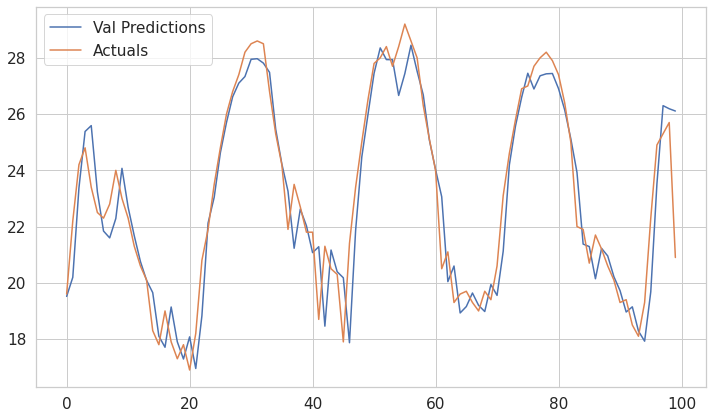




____________________________________________________________________________________________________
                                     Conv 1d Model - TEST DATA                                      


MAPE: 3.68%


      Test Predictions  Actuals
0            24.552900     20.0
1            19.583887     22.3
2            21.881536     23.9
3            23.978138     23.9
4            23.992159     21.7
...                ...      ...
8761         26.987970     28.1
8762         26.838449     23.6
8763         22.705923     23.6
8764         22.844698     22.3
8765         21.575369     21.3

[8766 rows x 2 columns]


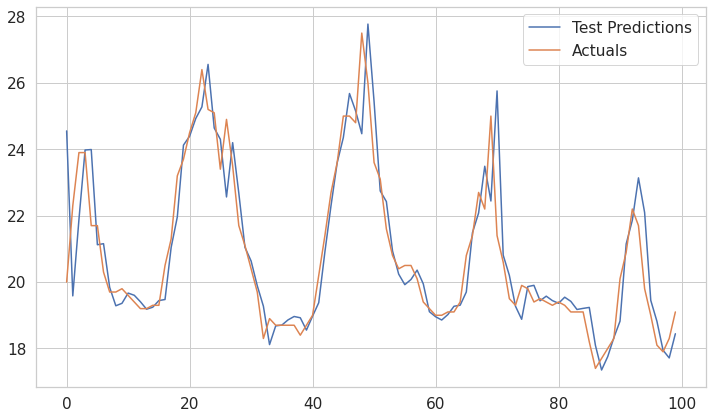

In [17]:
show_model(model_conv1d, X_train, y_train, X_val, y_val, X_test, y_test, model_name='Conv 1d')

## Second Model - Temperature, Time and Sliding Window

Some data is inherently cyclical. Time is a rich example of this: 
- Minutes; 
- Hours;
- Seconds;
- Day of the Week;
- Week of the Month;
- Month; 
- Season;

and so on all follow cycles.

---

We have already noted at the beginning of this notebook that our data have seasonality, meaning that this data is cyclical.

The thought behind it is not really an out-of-the-box idea, because usually during the day is hotter than in the middle of the night and during winter we have lower temperatures than in the summer. All of this can be fit in a 24 hours a day cycle and in a 365.2425 days a year cycle.

So this second model will try to use this information.

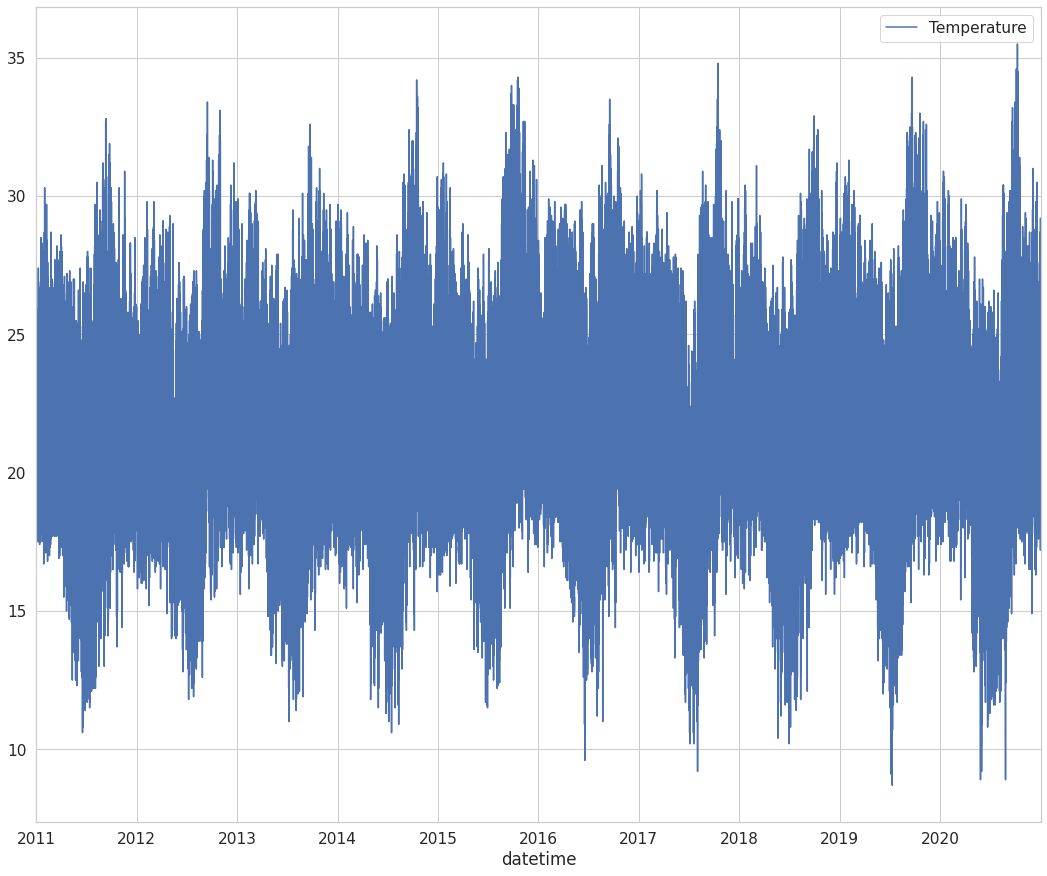

In [64]:
temp_df = pd.DataFrame({'Temperature':temperature_df})
temp_df.plot();

It is a noisy plot ( No need to plot all grouped plots again), but we can notice a cyclical pattern.

So the first step is to transform DateTime data into useful information.

When we are dealing with time-series data, it is also common that our dataframe's index has a DateTime format (YYYY-MM-DD HH:MM:SS) and it is true in our case too, because of that we will not extract much information from it, except the ascending order of data points. But there might be some hidden patterns in your dataset that will not be revealed by the regular features, so first we will need to transform them into timestamps

A ***timestamp*** basically represents a single instant, a specific point on the timeline, and its value corresponds to a certain amount of time elapsed from an initial instant. In our case, it is represented in seconds and will require some transformations to get it in a useful format.

In [65]:
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Temperature,Seconds
datetime,,
2011-01-01 00:00:00,19.2,1.293840e+09
2011-01-01 01:00:00,19.3,1.293844e+09
2011-01-01 02:00:00,19.1,1.293847e+09
2011-01-01 03:00:00,18.1,1.293851e+09
2011-01-01 04:00:00,17.7,1.293854e+09
...,...,...
2020-12-31 19:00:00,28.1,1.609441e+09
2020-12-31 20:00:00,23.6,1.609445e+09
2020-12-31 21:00:00,23.6,1.609448e+09


Now to extract information from the timestamps we need to get cyclical behavior from this, since we know that a day have 24 hours and a year have 365.2425 days, we can make an abstraction using Sin and Cosine in order to get cyclical behavior.

For example:  Cosine varies between -1 and 1 according to a 0–2π cycle.

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/cosine_2.gif" height="300px"></p>

It looks all set and done, but there is a catch:

As we can see in the gif above, at some point we will have diferent times with the same cosine, which will give our models the wrong idea that this 2 different hours are the same.

So we probably need to add another cyclical information in order to distinguish these two times with identical cosine values.

We could think of it as a two-axis coordinates system.

To solve this, we will use Sin and you can check it bellow:

<p align="center"><img src="https://www.math.hkust.edu.hk/~machiang/1013/Notes/sine_2.gif" height="300px"></p>

Combining Sin and Cosine we will have an unique coordinate for hours and year. Now we will transform our 'Seconds' using Sin and Cos.

In [66]:
# Getting Seconds in a Day
day = 60*60*24

# Getting Seconds in a Year
year = 365.2425*day

# Creating features out of sin and cos
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
datetime,,,,,,
2011-01-01 00:00:00,19.2,1.293840e+09,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,1.293844e+09,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,1.293847e+09,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,1.293851e+09,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,1.293854e+09,8.660254e-01,0.500000,0.003856,0.999993


Drop **Seconds** column since it is continuous and it will not add any information to the model.

In [67]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
datetime,,,,,
2011-01-01 00:00:00,19.2,-7.057106e-12,1.000000,0.000989,1.000000
2011-01-01 01:00:00,19.3,2.588190e-01,0.965926,0.001706,0.999999
2011-01-01 02:00:00,19.1,5.000000e-01,0.866025,0.002423,0.999997
2011-01-01 03:00:00,18.1,7.071068e-01,0.707107,0.003140,0.999995
2011-01-01 04:00:00,17.7,8.660254e-01,0.500000,0.003856,0.999993


In [68]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [69]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((87666, 6, 5), (87666,))

In [70]:
total_len = len(X2)
test_val_len = int(total_len * 0.10)
train_len = total_len - (2*test_val_len)

In [71]:
X2_train, y2_train = X2[:train_len], y2[:train_len]
X2_val, y2_val = X2[train_len:train_len + test_val_len], y2[train_len:train_len + test_val_len]
X2_test, y2_test = X2[train_len + test_val_len:], y2[train_len + test_val_len:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((70134, 6, 5), (70134,), (8766, 6, 5), (8766,), (8766, 6, 5), (8766,))

In [49]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

### Model - LSTM

In [83]:
model_LSTM_cyclic = train_model_LSTM(X2_train, y2_train, X2_val, y2_val, 'model_LSTM_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 12s 5ms/step - loss: 103.6799 - root_mean_squared_error: 10.1823 - mean_absolute_percentage_error: 30.0080 - val_loss: 4.9282 - val_root_mean_squared_error: 2.2200 - val_mean_absolute_percentage_error: 7.7917


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 10s 4ms/step - loss: 2.5034 - root_mean_squared_error: 1.5822 - mean_absolute_percentage_error: 5.5837 - val_loss: 1.8148 - val_root_mean_squared_error: 1.3472 - val_mean_absolute_percentage_error: 4.6542


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.2822 - root_mean_squared_error: 1.1323 - mean_absolute_percentage_error: 3.9012 - val_loss: 1.2954 - val_root_mean_squared_error: 1.1382 - val_mean_absolute_percentage_error: 3.8438


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.0317 - root_mean_squared_error: 1.0157 - mean_absolute_percentage_error: 3.4264 - val_loss: 1.1162 - val_root_mean_squared_error: 1.0565 - val_mean_absolute_percentage_error: 3.4774


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.9358 - root_mean_squared_error: 0.9674 - mean_absolute_percentage_error: 3.2065 - val_loss: 1.0687 - val_root_mean_squared_error: 1.0338 - val_mean_absolute_percentage_error: 3.3908


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.9011 - root_mean_squared_error: 0.9493 - mean_absolute_percentage_error: 3.1179 - val_loss: 1.0422 - val_root_mean_squared_error: 1.0209 - val_mean_absolute_percentage_error: 3.3095


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.8899 - root_mean_squared_error: 0.9433 - mean_absolute_percentage_error: 3.0840 - val_loss: 1.0234 - val_root_mean_squared_error: 1.0116 - val_mean_absolute_percentage_error: 3.2528


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.8837 - root_mean_squared_error: 0.9401 - mean_absolute_percentage_error: 3.0718 - val_loss: 1.0153 - val_root_mean_squared_error: 1.0076 - val_mean_absolute_percentage_error: 3.2355


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 10s 5ms/step - loss: 0.8782 - root_mean_squared_error: 0.9371 - mean_absolute_percentage_error: 3.0552 - val_loss: 1.0093 - val_root_mean_squared_error: 1.0046 - val_mean_absolute_percentage_error: 3.2081


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


INFO:tensorflow:Assets written to: model_LSTM_cyclic/assets


Epoch 10/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.8747 - root_mean_squared_error: 0.9353 - mean_absolute_percentage_error: 3.0515 - val_loss: 1.0096 - val_root_mean_squared_error: 1.0048 - val_mean_absolute_percentage_error: 3.2145


____________________________________________________________________________________________________
                                             LSTM Model                                             



____________________________________________________________________________________________________
                                      LSTM Model - TRAIN DATA                                       


MAPE: 3.06%


       Train Predictions  Actuals
0              18.310711     17.8
1              17.916113     18.0
2              18.112001     17.9
3              18.382607     17.9
4              18.996010     18.7
...                  ...      ...
70129          18.202494     18.2
70130          18.260071     18.4
70131          18.824715     18.0
70132          19.080368     18.7
70133          20.148916     19.0

[70134 rows x 2 columns]


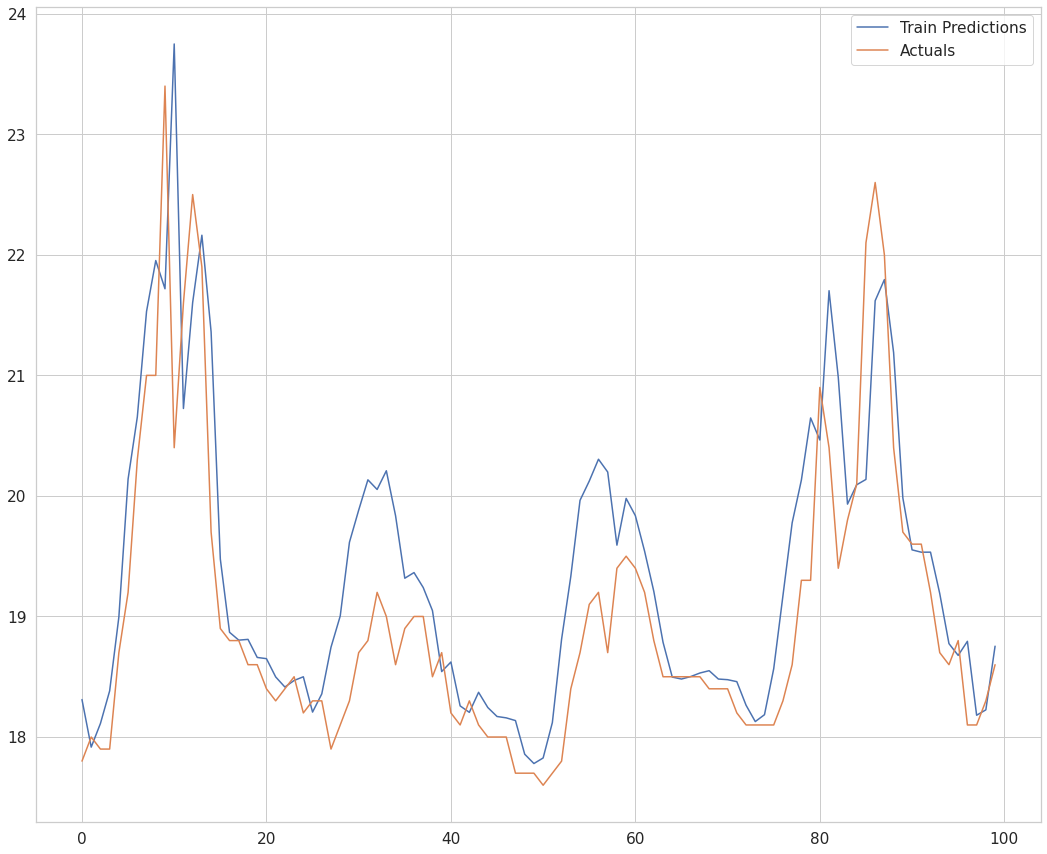




____________________________________________________________________________________________________
                                    LSTM Model - VALIDATION DATA                                    


MAPE: 3.21%


      Val Predictions  Actuals
0           20.480839     19.6
1           20.902102     22.2
2           23.122625     24.2
3           24.709145     24.8
4           24.977974     23.4
...               ...      ...
8761        23.476057     24.0
8762        24.738003     22.8
8763        23.329754     21.6
8764        22.012669     24.6
8765        24.647781     24.5

[8766 rows x 2 columns]


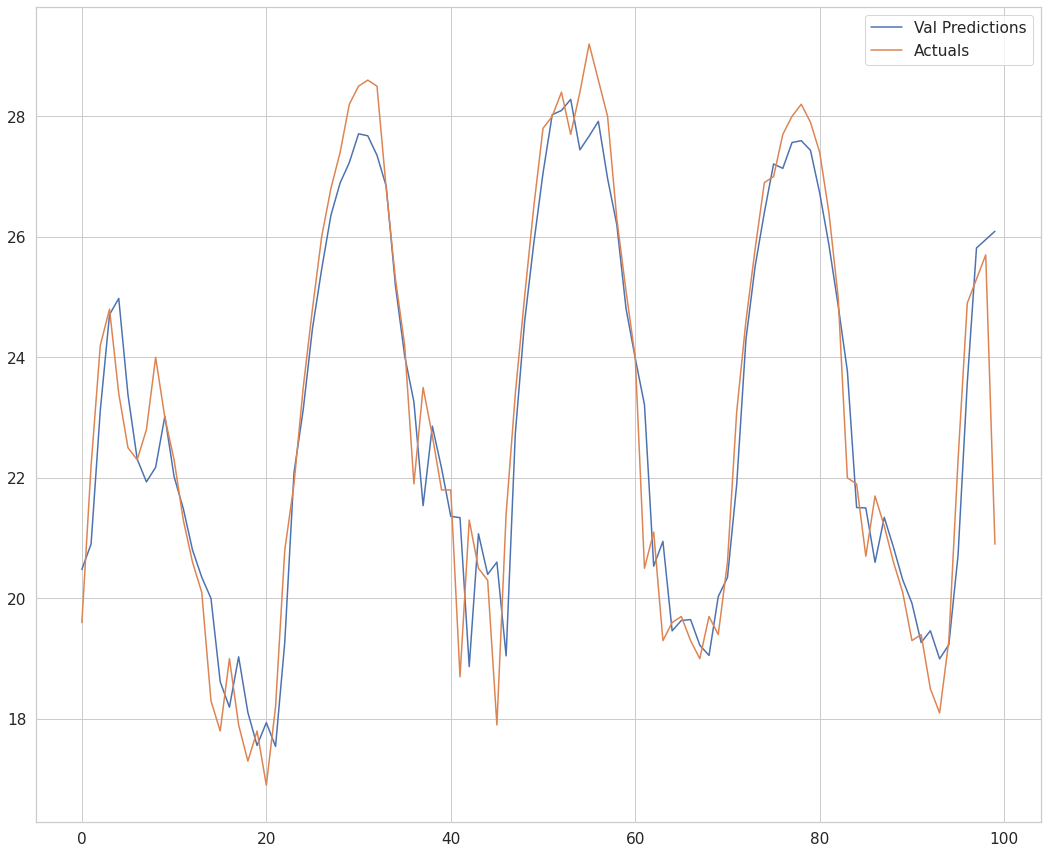




____________________________________________________________________________________________________
                                       LSTM Model - TEST DATA                                       


MAPE: 3.21%


      Test Predictions  Actuals
0            24.189877     20.0
1            19.995813     22.3
2            21.763420     23.9
3            22.986382     23.9
4            22.817890     21.7
...                ...      ...
8761         27.451992     28.1
8762         26.959267     23.6
8763         22.697525     23.6
8764         22.661751     22.3
8765         21.665806     21.3

[8766 rows x 2 columns]


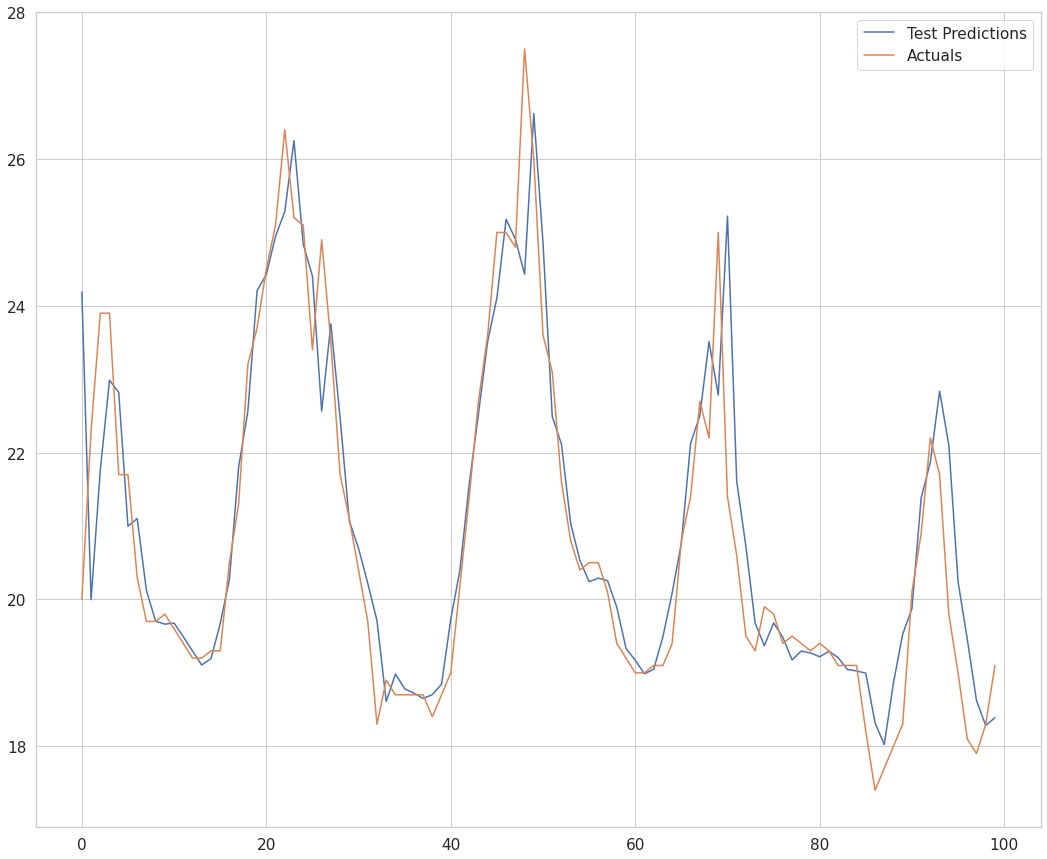

In [86]:
show_model(model_LSTM_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='LSTM')

### Model - GRU

In [84]:
model_GRU_cyclic = train_model_GRU(X2_train, y2_train, X2_val, y2_val, 'model_GRU_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 12s 5ms/step - loss: 115.9260 - root_mean_squared_error: 10.7669 - mean_absolute_percentage_error: 36.2717 - val_loss: 16.1718 - val_root_mean_squared_error: 4.0214 - val_mean_absolute_percentage_error: 14.6737


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 10s 5ms/step - loss: 6.9959 - root_mean_squared_error: 2.6450 - mean_absolute_percentage_error: 9.1500 - val_loss: 3.0584 - val_root_mean_squared_error: 1.7488 - val_mean_absolute_percentage_error: 5.8756


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.6503 - root_mean_squared_error: 1.2847 - mean_absolute_percentage_error: 4.4047 - val_loss: 1.4436 - val_root_mean_squared_error: 1.2015 - val_mean_absolute_percentage_error: 4.0643


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 10s 4ms/step - loss: 1.0623 - root_mean_squared_error: 1.0307 - mean_absolute_percentage_error: 3.4648 - val_loss: 1.1542 - val_root_mean_squared_error: 1.0744 - val_mean_absolute_percentage_error: 3.5521


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.9498 - root_mean_squared_error: 0.9746 - mean_absolute_percentage_error: 3.2138 - val_loss: 1.0849 - val_root_mean_squared_error: 1.0416 - val_mean_absolute_percentage_error: 3.3648


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 10s 4ms/step - loss: 0.9218 - root_mean_squared_error: 0.9601 - mean_absolute_percentage_error: 3.1460 - val_loss: 1.0709 - val_root_mean_squared_error: 1.0349 - val_mean_absolute_percentage_error: 3.3330


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 10s 5ms/step - loss: 0.9092 - root_mean_squared_error: 0.9535 - mean_absolute_percentage_error: 3.1147 - val_loss: 1.0509 - val_root_mean_squared_error: 1.0251 - val_mean_absolute_percentage_error: 3.2759


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 10s 5ms/step - loss: 0.9018 - root_mean_squared_error: 0.9496 - mean_absolute_percentage_error: 3.0974 - val_loss: 1.0438 - val_root_mean_squared_error: 1.0217 - val_mean_absolute_percentage_error: 3.2696


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 10s 5ms/step - loss: 0.8957 - root_mean_squared_error: 0.9464 - mean_absolute_percentage_error: 3.0883 - val_loss: 1.0349 - val_root_mean_squared_error: 1.0173 - val_mean_absolute_percentage_error: 3.2321


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


INFO:tensorflow:Assets written to: model_GRU_cyclic/assets


Epoch 10/10
2192/2192 [==============================] - 10s 5ms/step - loss: 0.8900 - root_mean_squared_error: 0.9434 - mean_absolute_percentage_error: 3.0795 - val_loss: 1.0424 - val_root_mean_squared_error: 1.0210 - val_mean_absolute_percentage_error: 3.2948


____________________________________________________________________________________________________
                                             GRU Model                                              



____________________________________________________________________________________________________
                                       GRU Model - TRAIN DATA                                       


MAPE: 3.1%


       Train Predictions  Actuals
0              18.044094     17.8
1              17.646248     18.0
2              17.800415     17.9
3              18.053873     17.9
4              18.738482     18.7
...                  ...      ...
70129          17.920147     18.2
70130          17.949503     18.4
70131          18.475119     18.0
70132          18.832750     18.7
70133          19.973446     19.0

[70134 rows x 2 columns]


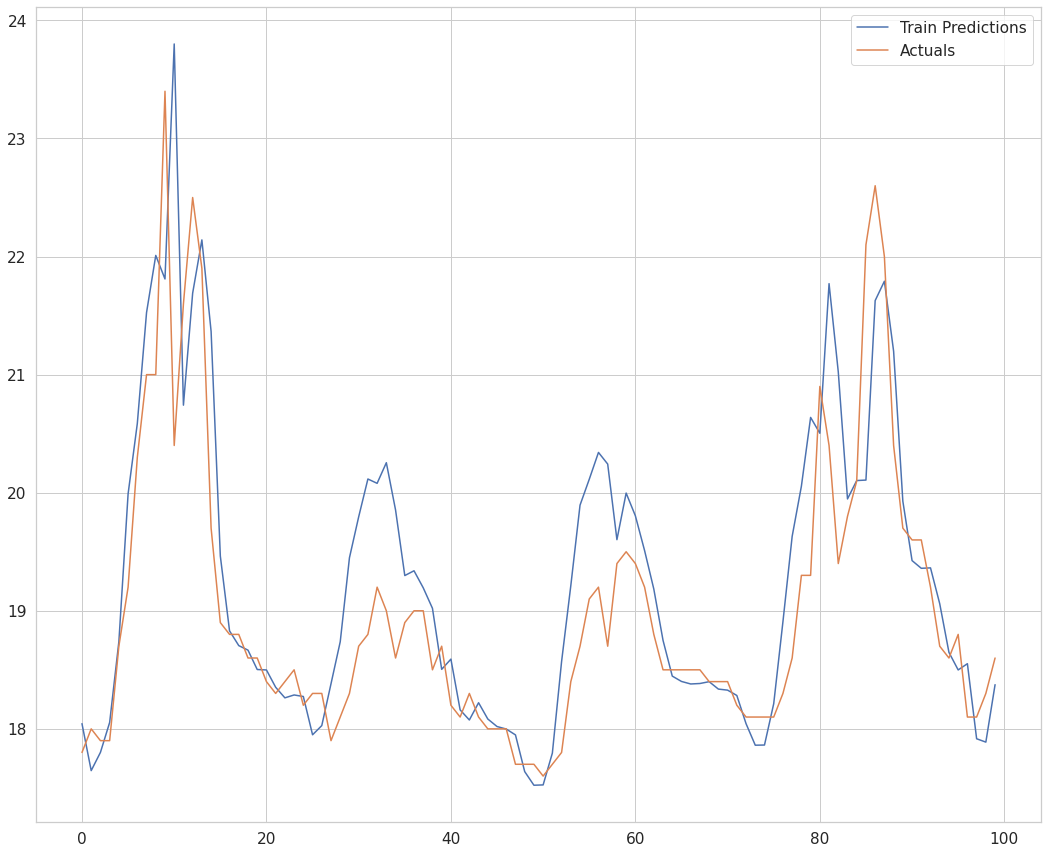




____________________________________________________________________________________________________
                                    GRU Model - VALIDATION DATA                                     


MAPE: 3.29%


      Val Predictions  Actuals
0           20.402786     19.6
1           20.898998     22.2
2           23.139748     24.2
3           24.714073     24.8
4           25.024811     23.4
...               ...      ...
8761        23.426662     24.0
8762        24.759098     22.8
8763        23.497301     21.6
8764        22.185156     24.6
8765        24.670145     24.5

[8766 rows x 2 columns]


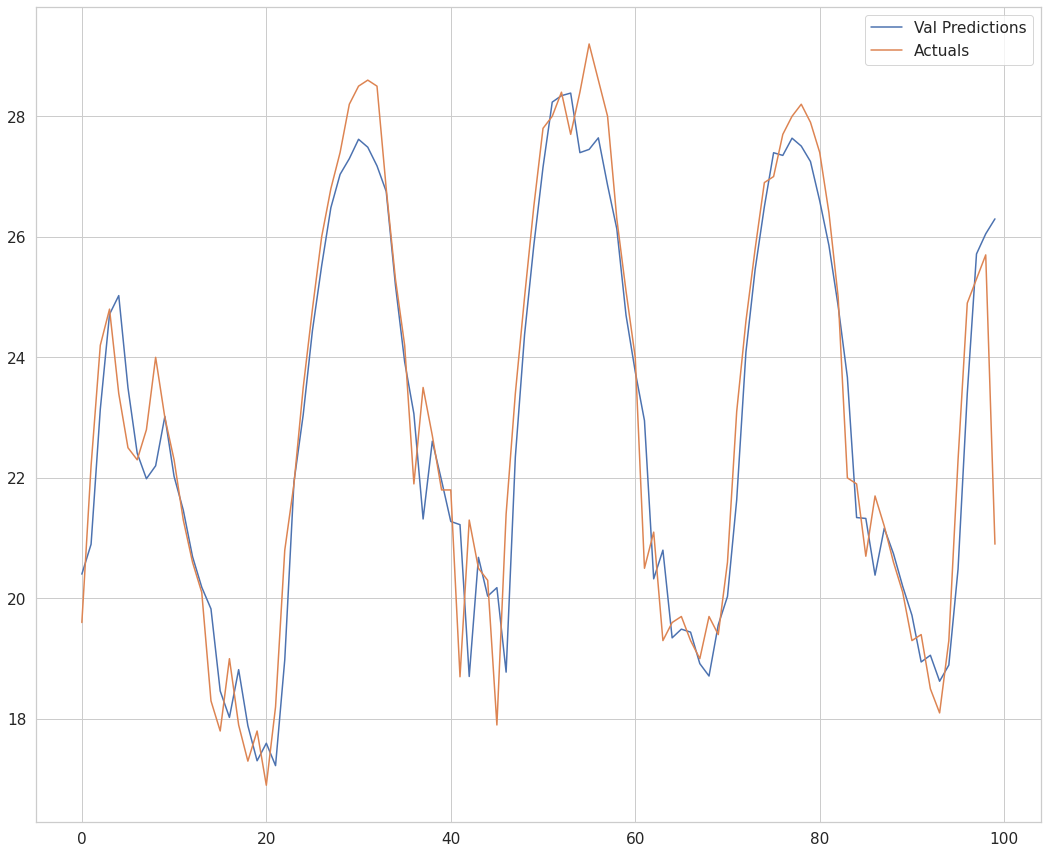




____________________________________________________________________________________________________
                                       GRU Model - TEST DATA                                        


MAPE: 3.26%


      Test Predictions  Actuals
0            24.115862     20.0
1            19.965555     22.3
2            21.934406     23.9
3            22.953085     23.9
4            22.753380     21.7
...                ...      ...
8761         27.287178     28.1
8762         26.791527     23.6
8763         22.749866     23.6
8764         22.697929     22.3
8765         21.536692     21.3

[8766 rows x 2 columns]


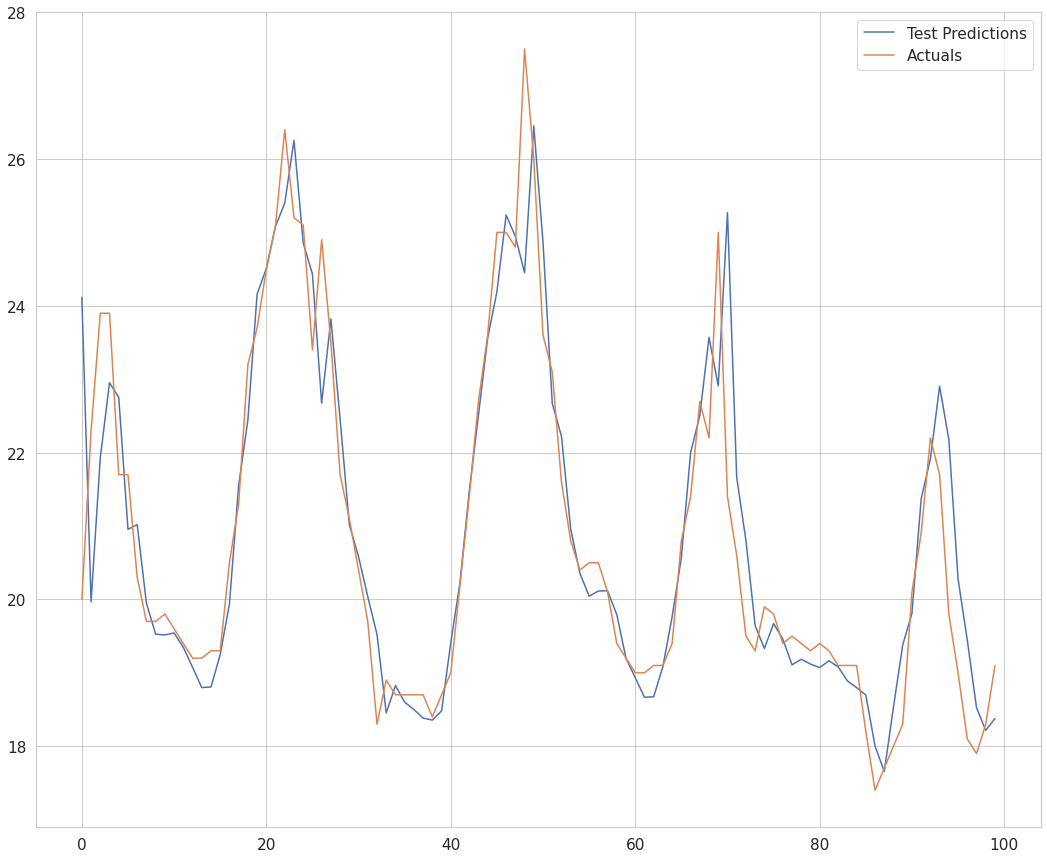

In [87]:
show_model(model_GRU_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='GRU')

### Model - Conv1d

In [88]:
model_conv1d_cyclic = train_model_conv1d(X2_train, y2_train, X2_val, y2_val, 'model_conv1d_cyclic', epochs=10, learning_rate=0.0001, input_layer=(6,5))

Epoch 1/10
2192/2192 [==============================] - 4s 2ms/step - loss: 185.3319 - root_mean_squared_error: 13.6137 - mean_absolute_percentage_error: 55.3720 - val_loss: 49.1016 - val_root_mean_squared_error: 7.0073 - val_mean_absolute_percentage_error: 27.3003
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 2/10
2192/2192 [==============================] - 3s 2ms/step - loss: 10.8544 - root_mean_squared_error: 3.2946 - mean_absolute_percentage_error: 11.2034 - val_loss: 2.3629 - val_root_mean_squared_error: 1.5372 - val_mean_absolute_percentage_error: 5.6467
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 3/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.7167 - root_mean_squared_error: 1.3102 - mean_absolute_percentage_error: 4.7837 - val_loss: 1.6858 - val_root_mean_squared_error: 1.2984 - val_mean_absolute_percentage_error: 4.5370
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 4/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.3338 - root_mean_squared_error: 1.1549 - mean_absolute_percentage_error: 4.0478 - val_loss: 1.3834 - val_root_mean_squared_error: 1.1762 - val_mean_absolute_percentage_error: 3.9933
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 5/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.1452 - root_mean_squared_error: 1.0701 - mean_absolute_percentage_error: 3.6702 - val_loss: 1.2518 - val_root_mean_squared_error: 1.1188 - val_mean_absolute_percentage_error: 3.7689
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 6/10
2192/2192 [==============================] - 3s 2ms/step - loss: 1.0624 - root_mean_squared_error: 1.0307 - mean_absolute_percentage_error: 3.4859 - val_loss: 1.2189 - val_root_mean_squared_error: 1.1041 - val_mean_absolute_percentage_error: 3.7043
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 7/10
2192/2192 [==============================] - 4s 2ms/step - loss: 1.0217 - root_mean_squared_error: 1.0108 - mean_absolute_percentage_error: 3.3883 - val_loss: 1.1577 - val_root_mean_squared_error: 1.0760 - val_mean_absolute_percentage_error: 3.5510
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 8/10
2192/2192 [==============================] - 3s 2ms/step - loss: 0.9949 - root_mean_squared_error: 0.9974 - mean_absolute_percentage_error: 3.3209 - val_loss: 1.1388 - val_root_mean_squared_error: 1.0672 - val_mean_absolute_percentage_error: 3.4866
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


Epoch 9/10
2192/2192 [==============================] - 4s 2ms/step - loss: 0.9778 - root_mean_squared_error: 0.9888 - mean_absolute_percentage_error: 3.2769 - val_loss: 1.1408 - val_root_mean_squared_error: 1.0681 - val_mean_absolute_percentage_error: 3.5200
Epoch 10/10
2192/2192 [==============================] - 3s 2ms/step - loss: 0.9652 - root_mean_squared_error: 0.9825 - mean_absolute_percentage_error: 3.2403 - val_loss: 1.1070 - val_root_mean_squared_error: 1.0521 - val_mean_absolute_percentage_error: 3.4168
INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


INFO:tensorflow:Assets written to: model_conv1d_cyclic/assets


____________________________________________________________________________________________________
                                            Conv1d Model                                            



____________________________________________________________________________________________________
                                     Conv1d Model - TRAIN DATA                                      


MAPE: 3.22%


       Train Predictions  Actuals
0              17.616739     17.8
1              17.648594     18.0
2              17.943924     17.9
3              17.714527     17.9
4              18.567284     18.7
...                  ...      ...
70129          17.933661     18.2
70130          18.115154     18.4
70131          18.210211     18.0
70132          18.676613     18.7
70133          20.146694     19.0

[70134 rows x 2 columns]


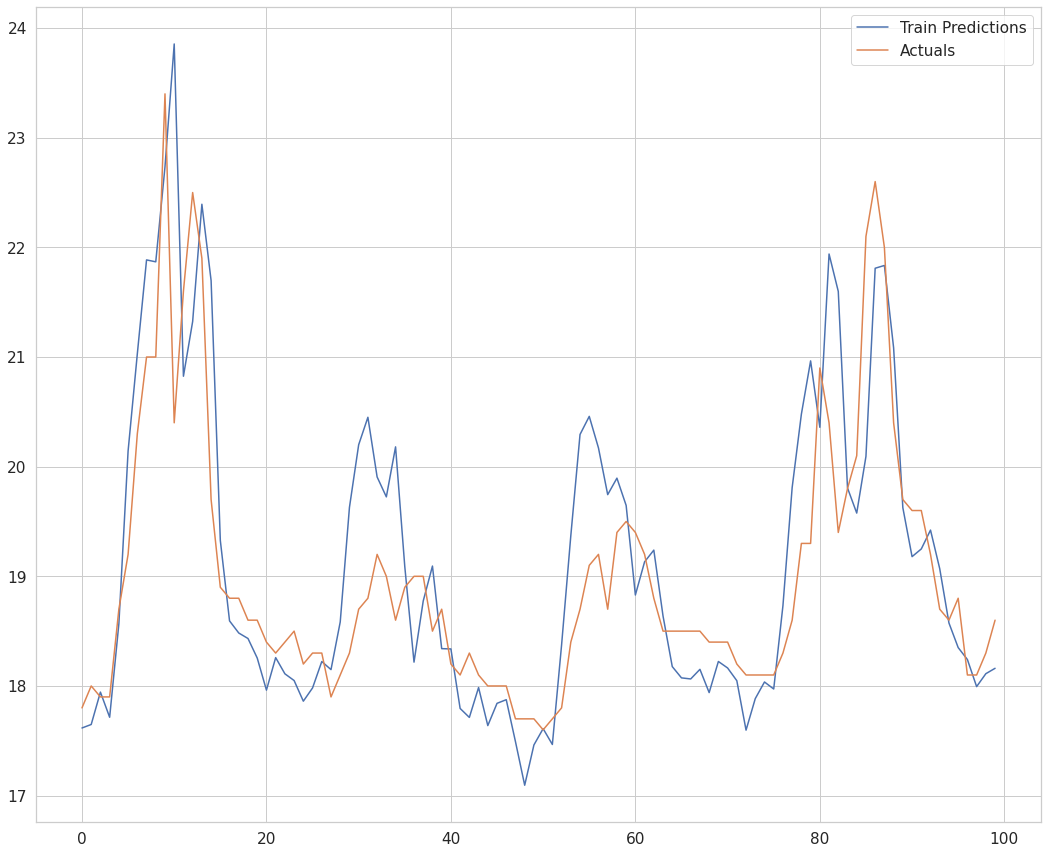




____________________________________________________________________________________________________
                                   Conv1d Model - VALIDATION DATA                                   


MAPE: 3.42%


      Val Predictions  Actuals
0           20.835421     19.6
1           21.273455     22.2
2           22.819082     24.2
3           25.247440     24.8
4           25.223503     23.4
...               ...      ...
8761        23.695032     24.0
8762        25.339281     22.8
8763        24.332470     21.6
8764        22.650658     24.6
8765        24.003803     24.5

[8766 rows x 2 columns]


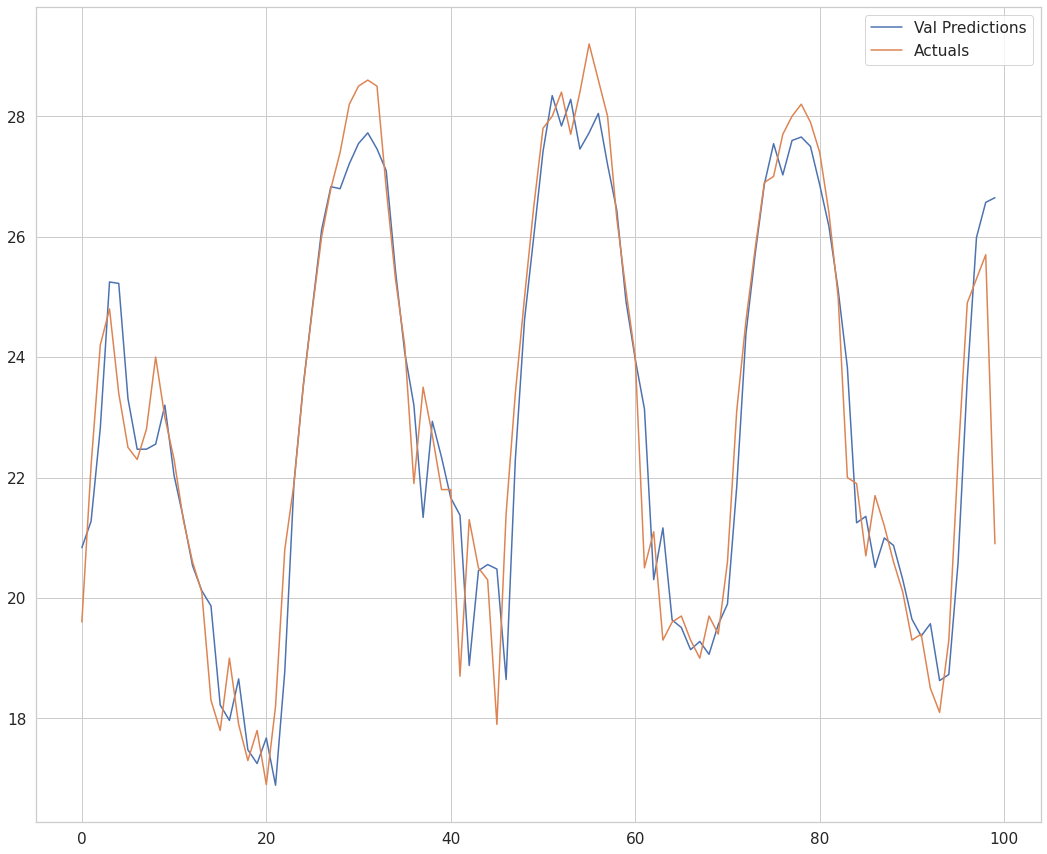




____________________________________________________________________________________________________
                                      Conv1d Model - TEST DATA                                      


MAPE: 3.38%


      Test Predictions  Actuals
0            23.969294     20.0
1            20.256409     22.3
2            22.028580     23.9
3            23.278290     23.9
4            22.890839     21.7
...                ...      ...
8761         27.369530     28.1
8762         27.149113     23.6
8763         22.918512     23.6
8764         22.790421     22.3
8765         21.625656     21.3

[8766 rows x 2 columns]


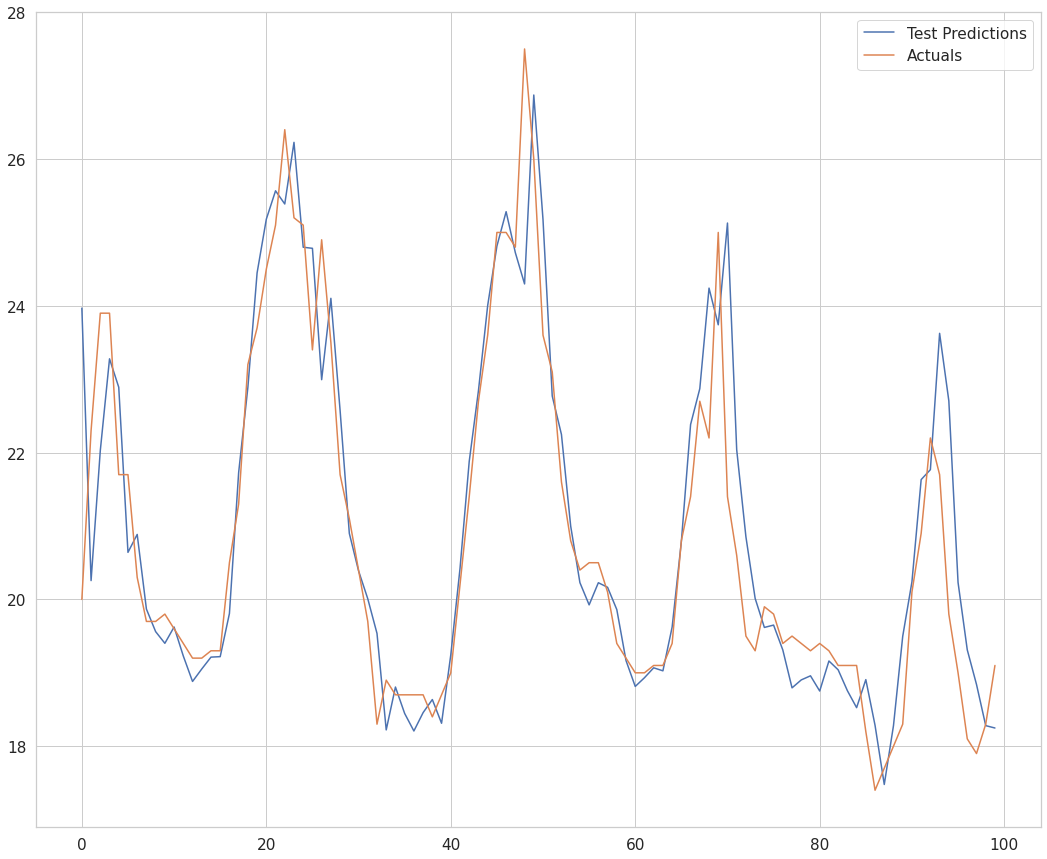

In [89]:
show_model(model_conv1d_cyclic, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, model_name='Conv1d')

### SKEWNESS and KURTOSIS

In [ ]:
from scipy.stats import kurtosis
from statistics import mean, mode, median
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import ticker

# Calculating coefficient of skewness ( Pearson's second coefficient of skewness )
skewness = (3 * (df['Temperature'].mean() - df['Temperature'].median())) / df['Temperature'].std()

print(f"Skewness: {round(skewness, 2)}")
print(f'Kurtosis: {round(kurtosis(df.Temperature), 2)}')

ax = sns.histplot(data=df, x='Temperature', kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} °C'))
plt.xticks(rotation=60)
plt.show()


# Calculating coefficient of skewness with log transformation ( Pearson's second coefficient of skewness )
df_log = np.log(df['Temperature'])
skewness_log = (3 * (df_log.mean() - df_log.median())) / df_log.std()

print(f"Skewness: {round(skewness_log, 2)}")
print(f'Kurtosis: {kurtosis(np.log(df["Temperature"]))}')
sns.histplot(data=df, x=np.log(df["Temperature"]), kde=True)
plt.xlabel('Temperature (Log Scale)')
plt.show()